In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from pathlib import Path
import itertools
import pickle
import seaborn as sns
import jax
import jax.numpy as np
import numpy
import scipy
import seaborn as sns
from tqdm import tqdm
jax.config.update('jax_platform_name', 'cpu')
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=16'

In [3]:
from sklearn.cluster import MiniBatchKMeans
seed = 42

In [4]:
from bomtemplate.bd_transformation import fc_phases_space, fc_space, activity_space
from bomtemplate.into_states import clustering
from bomtemplate.reliability_assessment import fingerprinting, predictive_power
from bomtemplate import utility
from bomtemplate import bd_preprocessing

In [5]:
cwd = os.getcwd()
head = Path(cwd).parents[2]
path_data = os.path.join(head, 'saved_data/')

In [6]:
path_figures = os.path.join(head, 'figures/emp/pepr_April2024/Eida')
path_figures

'/home/anastasios/Marseille/projects/brain_screening/figures/emp/pepr_April2024/Eida'

In [7]:
getdata = bd_preprocessing.Get_1000Brains_Data(path_data)
output_dict = getdata.get_data(bins=False)
output_dict.keys()

dict_keys(['data_3d', 'ages', 'TR', 'transient'])

In [8]:
ages = output_dict['ages']

In [9]:
transient = output_dict['transient']
data_3d = output_dict['data_3d'][:,transient:]
n_participants, n_samples, n_nodes = data_3d.shape

In [10]:
lowcut = 0.01
highcut = 0.08
data_3d_filtered = numpy.zeros_like(data_3d)
for p in range(n_participants):
    data_3d_filtered [p] = bd_preprocessing.butter_bandpass_filter(data_3d[p], axis=0, lowcut=lowcut, highcut=highcut, fs=1, order=1)

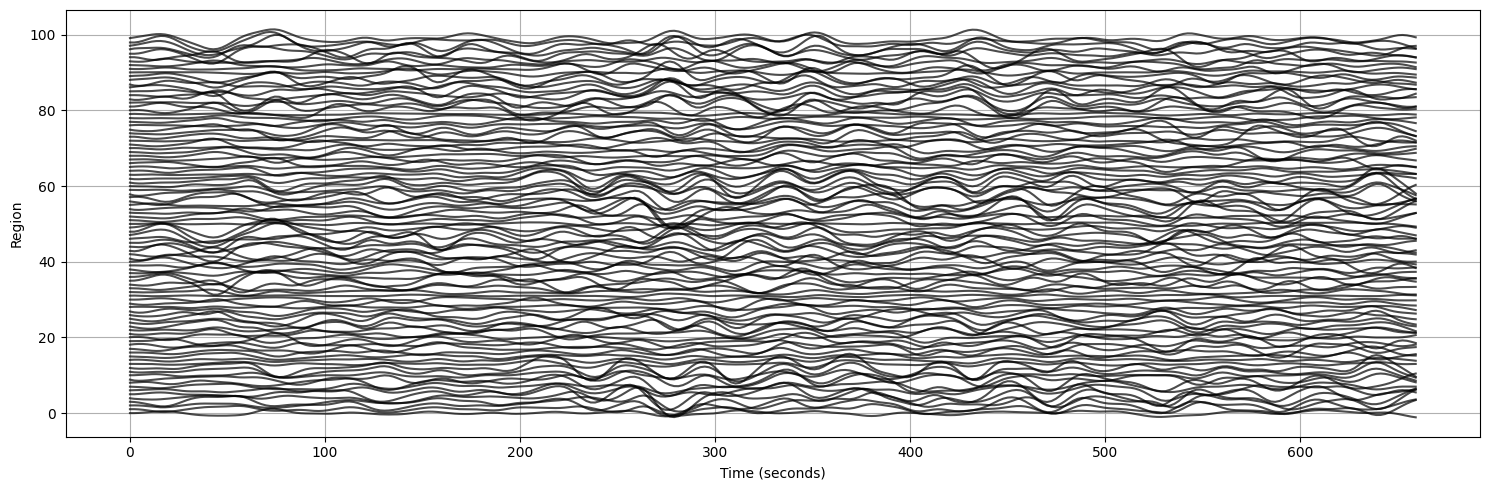

In [11]:
TR = output_dict['TR']
bd_preprocessing.plot_filtered_ts(data_3d_filtered[9], TR=TR)

In [12]:
ei = fc_phases_space.Eida(return_iPL=False)
ls, vs = ei.fit_transform(data_3d_filtered)

In [13]:
iPL = jax.vmap(fc_phases_space.FC_stream_phases, in_axes=0)(data_3d_filtered)

In [40]:
iPL.shape

(648, 294, 100, 100)

In [15]:
reconf_speed = []
for i in tqdm(range(int(n_participants))):
    reconf_speed.append(ei.reconfiguration_speed(iPL[i]))
reconf_speed = np.asarray(reconf_speed)

  0%|          | 0/648 [00:00<?, ?it/s]

100%|██████████| 648/648 [00:20<00:00, 31.65it/s]


In [16]:
kur_ms = ei.kuramoto_metastability()
sr = ei.spectral_radius()

#### spectral metastability

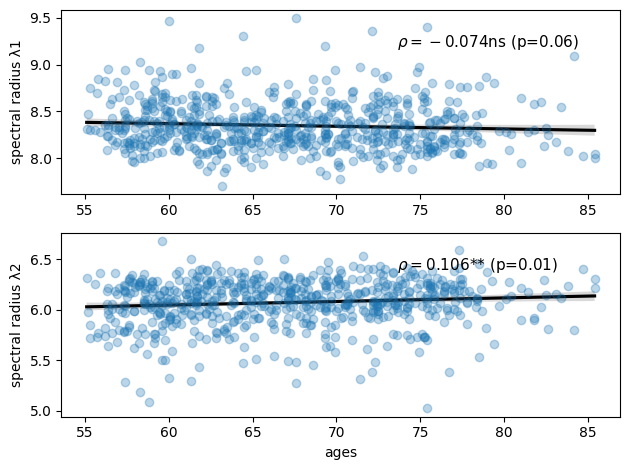

In [35]:
y1, y2 = sr
subplot(211)
sns.regplot(x=ages, y=y1,
            line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
slope,_,r_value,p_value,_ = scipy.stats.linregress(x=ages, y=y1)
annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)} (p={p_value:0.02f})',
         xy=(0.6, 0.8), xycoords='axes fraction', fontsize=11)
ylabel('spectral radius λ1')
subplot(212)
sns.regplot(x=ages, y=y2,
            line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
slope,_,r_value,p_value,_ = scipy.stats.linregress(x=ages, y=y2)
annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)} (p={p_value:0.02f})',
         xy=(0.6, 0.8), xycoords='axes fraction', fontsize=11)
ylabel('spectral radius λ2')
xlabel('ages')
tight_layout()
# savefig(os.path.join(head, path_figures, 'spectral_radius.png'), dpi=250, bbox_inches='tight')
plt.show()

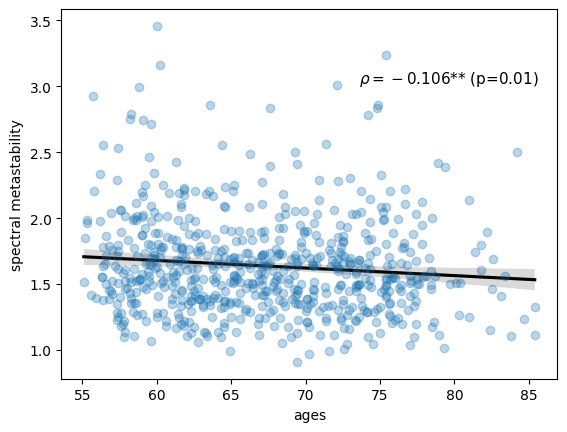

In [36]:
y = ei.spectral_metastability()
sns.regplot(x=ages, y=y,
            line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
slope,_,r_value,p_value,_ = scipy.stats.linregress(x=ages, y=y)
annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)} (p={p_value:0.02f})',
         xy=(0.6, 0.8), xycoords='axes fraction', fontsize=11)
xlabel('ages')
ylabel('spectral metastability')
# savefig(os.path.join(head, path_figures, 'spectral_metastability.png'), dpi=250, bbox_inches='tight')
plt.show()

#### kuramoto metastability

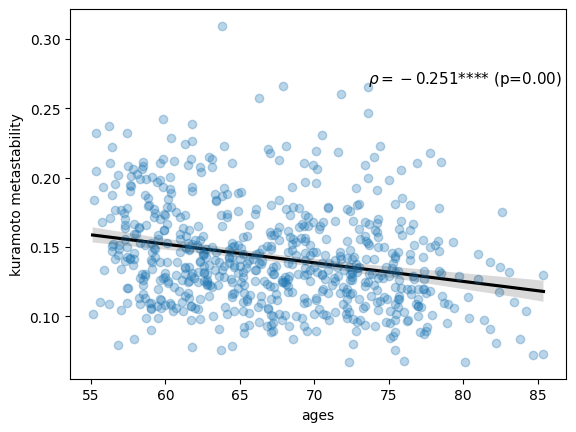

In [37]:
y = ei.kuramoto_metastability()
sns.regplot(x=ages, y=y,
            line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
slope,_,r_value,p_value,_ = scipy.stats.linregress(x=ages, y=y)
annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)} (p={p_value:.2f})',
         xy=(0.6, 0.8), xycoords='axes fraction', fontsize=11)
xlabel('ages')
ylabel('kuramoto metastability')
# savefig(os.path.join(head, path_figures, 'kuramoto_metastability.png'), dpi=250, bbox_inches='tight')
plt.show()

#### reconfiguration speed

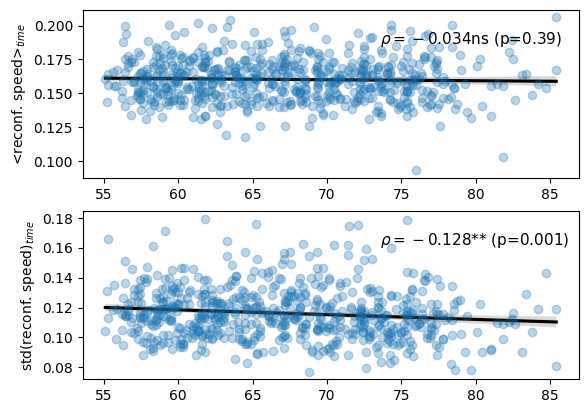

In [38]:
y1, y2 = reconf_speed.mean(-1), reconf_speed.std(-1)
subplot(211)
sns.regplot(x=ages, y=y1,
            line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
slope,_,r_value,p_value,_ = scipy.stats.linregress(x=ages, y=y1)
annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)} (p={p_value:0.02f})',
         xy=(0.6, 0.8), xycoords='axes fraction', fontsize=11)
ylabel('<reconf. speed>$_{time}$')
subplot(212)
sns.regplot(x=ages, y=y2,
            line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
slope,_,r_value,p_value,_ = scipy.stats.linregress(x=ages, y=y2)
annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)} (p={p_value:0.03f})',
         xy=(0.6, 0.8), xycoords='axes fraction', fontsize=11)
ylabel('std(reconf. speed)$_{time}$')
# savefig(os.path.join(head, path_figures, 'reconfiguration_speed.png'), dpi=250, bbox_inches='tight')
plt.show()